In [1]:
%matplotlib inline
from mocpy import MOC
import numpy as np

In [2]:
order = 5
#npix = 12*4**(order)
#moc = MOC.from_json({str(order): np.random.randint(npix, size=npix//2)})

fits_path = '../mocpy/notebooks/demo-data/P-SDSS9-r.fits'
moc = MOC.from_fits(fits_path)
moc = moc.degrade_to_order(order)

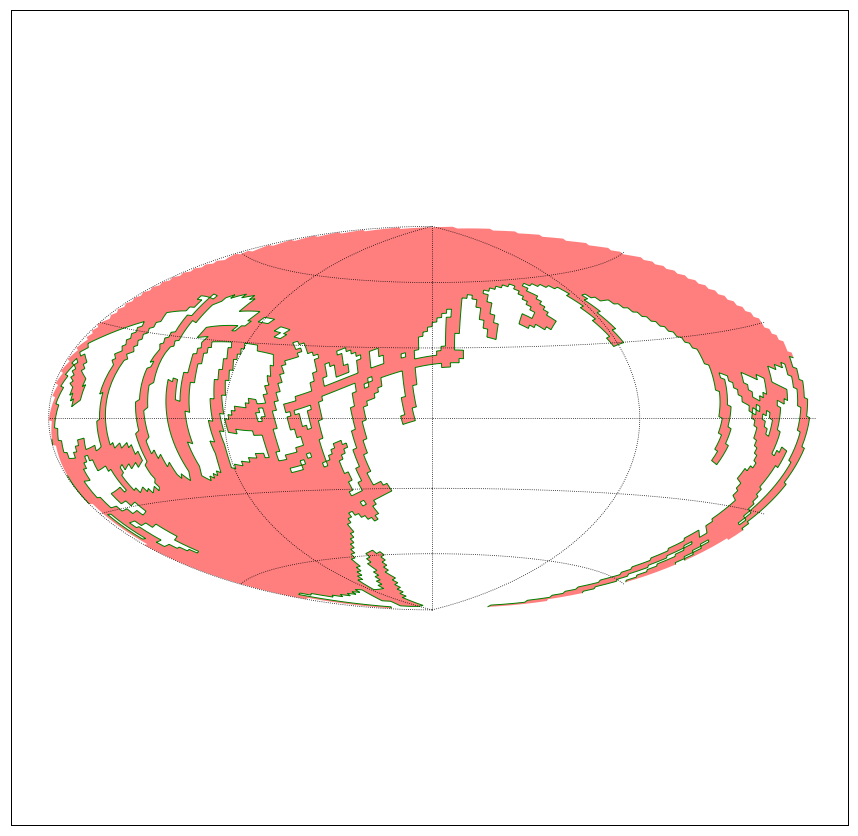

In [3]:
# A function creating all the matplotlib context for plotting a MOC with its perimeter
def plot(moc, wcs, title=''):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs})
    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color='r')
    moc.perimeter(ax=ax, wcs=wcs, color='g')

    plt.axis('equal')
    plt.xlabel('ra')
    plt.ylabel('dec')
    if title:
        plt.title(title)
    plt.grid(color="black", linestyle="dotted")
    plt.show()


from mocpy.utils import make_wcs
wcs_galactic = make_wcs(crpix=[0, 0], crval=[0, 0], cdelt=[-5, 5], ctype=["GLON-AIT", "GLAT-AIT"])

plot(moc, wcs_galactic)

In [4]:
if moc.max_order > 8:
    moc = moc.degrade_to_order(8)

max_order = moc.max_order
from astropy_healpix import HEALPix
from astropy.coordinates import ICRS
hp = HEALPix(nside=(1 << max_order), order='nested', frame=ICRS())
ipixels_open = moc._best_res_pixels()

# Take the complement if the MOC covers more than half of the sky => the perimeter(MOC) = perimeter(complement(MOC))
# but we process less hpx cells
num_ipixels = 3 << (2*(max_order + 1))
sky_fraction = ipixels_open.shape[0] / float(num_ipixels)

if sky_fraction > 0.5:
    ipixels_all = np.arange(num_ipixels)
    ipixels_open = np.setdiff1d(ipixels_all, ipixels_open, assume_unique=True)

In [5]:
# a python module handling graph manipulations
import networkx as nx

In [6]:
# Split the MOC into all its connexe components by creating an adjencency matrix
# of the ipix of the MOC.

# Create a adjencency matrix of the moc ipixels
adj = np.zeros(shape=(ipixels_open.shape[0], ipixels_open.shape[0]), dtype=np.int8)
# Set the correspondance between HEALPix ids and the node ids
to_node_id = {k: v for k, v in np.vstack((ipixels_open, np.arange(adj.shape[0]))).T}
to_hpx_id = {k: v for k, v in np.vstack((np.arange(adj.shape[0]), ipixels_open)).T}

# Get the neighbours of all these pixels
neighbours = hp.neighbours(ipixels_open)
# Select only the WEST, SOUTH, EAST and NORTH neighbours (i.e. the direct ones)
neighbours = neighbours[[0, 2, 4, 6], :]

# Check whether the neighbours are in the MOC
neighbours_in_moc = np.isin(neighbours, ipixels_open)

# Fill the adjencency matrix
for i in range(adj.shape[0]):
    for k in range(neighbours.shape[0]):
        ipix_neigh = neighbours[k, i]
        if neighbours_in_moc[k, i]:
            j = to_node_id[ipix_neigh]
            adj[i, j] += 1

In [7]:
# Compute the graph from its adjencency matrix.
# https://en.wikipedia.org/wiki/Adjacency_matrix

# This operation can take some time, especially if the MOC (or its complement) contains a lot of ipix
G=nx.from_numpy_matrix(adj)

In [8]:
# Some plotting functions
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

# To add a perimeter to the plot
def add_patch_path(ax, wcs, lon, lat, **kw_mpl_pathpatch):
    from astropy.coordinates import SkyCoord
    from astropy.wcs.utils import skycoord_to_pixel
    coords = SkyCoord(lon, lat)

    xp, yp = skycoord_to_pixel(coords=coords, wcs=wcs)
    codes = np.ones(shape=(xp.shape[0]+1,))*Path.LINETO
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    
    vertices = np.vstack((xp, yp)).T.tolist()
    vertices.append(vertices[0])
    
    path = Path(vertices, codes)

    patch = PathPatch(path, **kw_mpl_pathpatch)
    ax.add_patch(patch)

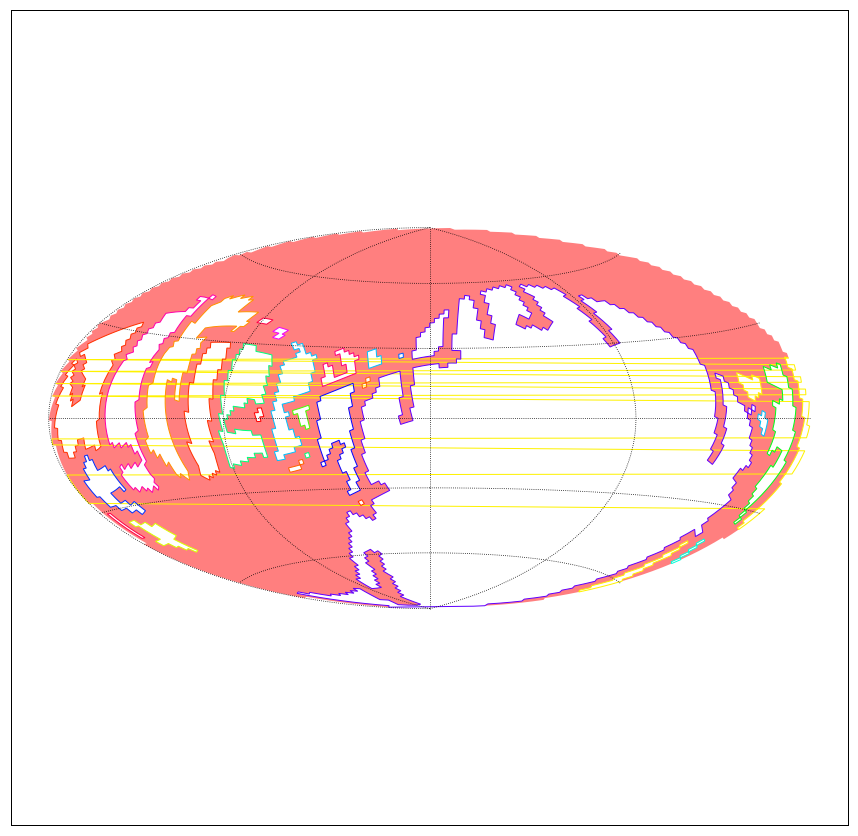

In [9]:
# Init the plot
import matplotlib.pyplot as plt
cmap = get_cmap(32)
fig, ax = plt.subplots(1, 1, figsize=(15, 15), subplot_kw={"projection": wcs_galactic})
# Draw the MOC
moc.fill(ax=ax, wcs=wcs_galactic, alpha=0.5, fill=True, color='r')

# This method is called when creating the graph of positions of a specific MOC component
def insert_edge(G, pts_d, pt1, pt2):
    # Nodes are indexed by str(skycoord). When getting ordered nodes, one can retrieve back the skycoord instance
    # by accessing the python dict `pts_d`.
    k1 = str(pt1)
    k2 = str(pt2)
    if k1 in pts_d:
        # Avoid this special case where holes are touching to each other
        # 'x' belongs to the MOC
        # ' ' does not belong to the MOC
        #    |xxx
        #    |xxx
        # ---A--- 
        # xxx|
        # xxx|
        #
        # If this case occurs we split the node A into 2. One is attached to the bottom left graph and the other to the
        # top right one. When computing the MST (minimal spanning tree) from a graph, we need our graphs to have
        # only nodes of degrees 1 or 2 (i.e. to be lines).
        # Therefore each hole in the MOC will be associated to a separate perimeter.
        if G.degree[k1] == 2:
            k1 += '2'
            pts_d[k1] = pt1
    else:
        pts_d[k1] = pt1
    
    if k2 in pts_d:  
        if G.degree[k2] == 2:
            k2 += '2'
            pts_d[k2] = pt2
    else:
        pts_d[k2] = pt2
    
    G.add_edge(k1, k2)

# Access the separated components of the global MOC
for g in nx.connected_component_subgraphs(G):
    # g is a connexe graph that can contains holes 
    nodes_id = g.nodes

    hpx_ids = []
    for node_id in nodes_id:
        hpx_ids.append(to_hpx_id[node_id])

    pts_d = {}
    # Retrieve only the ipix being in the border of the MOC component
    hpx_ids = np.asarray(hpx_ids)
    neighbours = hp.neighbours(hpx_ids)[[0, 2, 4, 6], :]
    isin = np.isin(neighbours, ipixels_open)
    border = isin.sum(axis=0) < 4
    
    hpx_border_ids = hpx_ids[border]
    isin_border = isin[:, border]
    boundaries = hp.boundaries_skycoord(hpx_border_ids, step=1)
    
    # create the graph of the skycoords for this component (will only contain cycles. One cycle for the external perimeter
    # of the component, and several smaller cycles for the internal holes).
    H = nx.Graph()
    
    for i in range(hpx_border_ids.shape[0]):
        hpx_id = hpx_border_ids[i]
        ipix_bound = boundaries[i]

        # WEST border
        if not isin_border[0, i]:
            pt1 = ipix_bound[1]
            pt2 = ipix_bound[2]
            insert_edge(H, pts_d, pt1, pt2)
            
        # NORTH border
        if not isin_border[3, i]:
            pt2 = ipix_bound[2]
            pt3 = ipix_bound[3]
            insert_edge(H, pts_d, pt2, pt3)
            
        # EAST border
        if not isin_border[2, i]:
            pt0 = ipix_bound[0]
            pt3 = ipix_bound[3]
            insert_edge(H, pts_d, pt3, pt0)
            
        # SOUTH border
        if not isin_border[1, i]:
            pt0 = ipix_bound[0]
            pt1 = ipix_bound[1]
            insert_edge(H, pts_d, pt0, pt1)
    
    # Accessing the cycles one by one
    for h_connexe in nx.connected_component_subgraphs(H):
        # Compute the MST for each cycle
        span_tree = nx.minimum_spanning_tree(h_connexe)
        # Get one end of the span tree by looping over its node and checking if the degree is one
        source = None
        for (node, deg) in span_tree.degree():
            if deg == 1:
                source = node
                break
        p_coords_lon = []
        p_coords_lat = []
        # Do a Depth First Search along the spanning tree starting from the source
        for node in nx.dfs_preorder_nodes(span_tree, source):
            p_coords_lon.append(pts_d[node].ra)
            p_coords_lat.append(pts_d[node].dec)

        color = cmap(np.random.randint(32))
        # p_coords_lon/lat follow the perimeter and can be plotted using a MPL path patch
        add_patch_path(ax, wcs_galactic, p_coords_lon, p_coords_lat, color=color, fill=False)

# Show the plot
plt.axis('equal')
plt.xlabel('ra')
plt.ylabel('dec')
plt.grid(color="black", linestyle="dotted")
plt.show()